# Time to Fail

One of the machine learning requests that we would like to create greater visibility into and for a given test, to build a model that can predict an optimal stopping point, beyond which a test is more likely to result in a failure.

In order to achieve the above, we would be looking into the data for all the passing and failed tests and find the distribution type for the `test_duration` metric. The `test_duration` metric tracks the time it took for a test to complete its execution. We can visualize the distribution of the test_duration metric across various testgrid dashboards and jobs. Based on the distribution type identified, we can find a point after which the test has a higher probability of failing.

Linked issue(s) : [Issue1](https://github.com/aicoe-aiops/ocp-ci-analysis/issues/333), [Issue2](https://github.com/aicoe-aiops/ocp-ci-analysis/issues/226)

In [1]:
import json
import gzip
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
import scipy.stats
import itertools
from intersect import intersection
from sklearn.preprocessing import StandardScaler
from scipy.stats import invgauss, lognorm, pearson3, weibull_min, triang, beta

from ipynb.fs.defs.metric_template import testgrid_labelwise_encoding
from ipynb.fs.defs.metric_template import CephCommunication
from dotenv import load_dotenv, find_dotenv
import warnings

warnings.filterwarnings("ignore")

load_dotenv(find_dotenv())

True

## Ceph
Connection to Ceph for importing the TestGrid data

In [2]:
## Specify variables

METRIC_NAME = "time_to_fail"

# Specify the path for input grid data
INPUT_DATA_PATH = "../../../../data/raw/testgrid_258.json.gz"

# Specify the path for output metric data
OUTPUT_DATA_PATH = f"../../../../data/processed/metrics/{METRIC_NAME}"

## CEPH Bucket variables
## Create a .env file on your local with the correct configs
s3_endpoint_url = os.getenv("S3_ENDPOINT")
s3_access_key = os.getenv("S3_ACCESS_KEY")
s3_secret_key = os.getenv("S3_SECRET_KEY")
s3_bucket = os.getenv("S3_BUCKET")
s3_path = os.getenv("S3_PROJECT_KEY", "metrics")
s3_input_data_path = "raw_data"

# Specify whether or not we are running this as a notebook or part of an automation pipeline.
AUTOMATION = os.getenv("IN_AUTOMATION")

In [3]:
## Import data
timestamp = datetime.datetime.today()

if AUTOMATION:
    filename = f"testgrid_{timestamp.day}{timestamp.month}.json"
    cc = CephCommunication(s3_endpoint_url, s3_access_key, s3_secret_key, s3_bucket)
    s3_object = cc.s3_resource.Object(s3_bucket, f"{s3_input_data_path}/{filename}")
    file_content = s3_object.get()["Body"].read().decode("utf-8")
    testgrid_data = json.loads(file_content)

else:
    with gzip.open(INPUT_DATA_PATH, "rb") as read_file:
        testgrid_data = json.load(read_file)

## Helper Functions

In [4]:
# Function to filter the df for a specified test
def filter_test_type(df, test):
    failures_test = df[df["test"] == test]
    failures_test = failures_test.reset_index(drop=True)
    return failures_test

In [5]:
def standardize(df, column, pct, pct_lower):
    """
    Function to standardize the features by removing the mean
    and scaling to unit variance using StandardScaler library.

    Returns standandardized feature, length of the feature
    and the original feature.
    """
    sc = StandardScaler()
    y = df[column][df[column].notnull()].to_list()
    y.sort()
    len_y = len(y)
    y = y[int(pct_lower * len_y) : int(len_y * pct)]
    len_y = len(y)
    yy = [[x] for x in y]
    sc.fit(yy)
    y_std = sc.transform(yy)
    y_std = y_std.flatten()
    return y_std, len_y, y

In [6]:
def fit_distribution(df, column, pct, pct_lower):
    """
    This function helps to list out the chi-square statistics for each
    distribution and further sorts them to find the best distribution.

    Returns a table that contains sorted chi-square values as well as
    the parameters such as mu (shape), loc (location) and scale for each
    distribution.
    """
    # Set up list of candidate distributions to use
    y_std, size, y_org = standardize(df, column, pct, pct_lower)
    dist_names = [
        "weibull_min",
        "norm",
        "weibull_max",
        "beta",
        "invgauss",
        "uniform",
        "gamma",
        "expon",
        "lognorm",
        "pearson3",
        "triang",
    ]

    chi_square_statistics = []

    # 50 bins
    percentile_bins = np.linspace(0, 100, 50)
    percentile_cutoffs = np.percentile(y_std, percentile_bins)
    observed_frequency, bins = np.histogram(y_std, bins=percentile_cutoffs)
    cum_observed_frequency = np.cumsum(observed_frequency)
    # Data frame to store results
    dist_param = pd.DataFrame()
    dist_param["Distribution Names"] = dist_names
    param_list = []

    # Loop through candidate distributions
    for distribution in dist_names:
        # Set up distribution and get fitted distribution parameters
        dist = getattr(scipy.stats, distribution)
        param = dist.fit(y_std)
        param_list.append(param)

        # Get expected counts in percentile bins
        # cdf of fitted distribution across bins
        cdf_fitted = dist.cdf(percentile_cutoffs, *param)
        expected_frequency = []
        for bin in range(len(percentile_bins) - 1):
            expected_cdf_area = cdf_fitted[bin + 1] - cdf_fitted[bin]
            expected_frequency.append(expected_cdf_area)

        # Chi-square Statistics
        expected_frequency = np.array(expected_frequency) * size
        cum_expected_frequency = np.cumsum(expected_frequency)
        ss = scipy.stats.chisquare(
            f_obs=cum_observed_frequency, f_exp=cum_expected_frequency
        )
        chi_square_statistics.append(ss)

    # Append results to data frame
    dist_param["Parameters"] = param_list
    dist_param.set_index("Distribution Names")
    # Sort by minimum ch-square statistics
    results = pd.DataFrame()
    results["Distribution"] = dist_names
    results["chi_square and p-value"] = chi_square_statistics
    results.sort_values(["chi_square and p-value"], inplace=True)

    print("\nDistributions listed by Betterment of fit:")
    print("............................................")
    print(results)
    return dist_param, results

## Calculation
Let's fetch all the tests which are "Passing" and "Failing".

### Failing Tests

In [7]:
# We will now fetch all the tests which are failing i.e. have a status code of 12.
failures_list = testgrid_labelwise_encoding(testgrid_data, 12, overall_only=False)

In [8]:
# Convert to dataframe
failures_df = pd.DataFrame(
    failures_list,
    columns=["timestamp", "tab", "grid", "test", "test_duration", "failure"],
)
failures_df.head()

timestamp                          tab  \
0 2021-08-25 14:51:42  "redhat-assisted-installer"   
1 2021-08-23 00:01:04  "redhat-assisted-installer"   
2 2021-08-22 08:53:17  "redhat-assisted-installer"   
3 2021-08-20 23:21:32  "redhat-assisted-installer"   
4 2021-08-20 15:57:36  "redhat-assisted-installer"   

                                                grid     test  test_duration  \
0  periodic-ci-openshift-release-master-nightly-4...  Overall            NaN   
1  periodic-ci-openshift-release-master-nightly-4...  Overall      95.300000   
2  periodic-ci-openshift-release-master-nightly-4...  Overall     101.800000   
3  periodic-ci-openshift-release-master-nightly-4...  Overall     134.833333   
4  periodic-ci-openshift-release-master-nightly-4...  Overall     109.833333   

   failure  
0    False  
1    False  
2    False  
3    False  
4    False

In [9]:
len(failures_df)

36046950

In [10]:
# We will drop all the rows having NaN values
failures_df = failures_df.dropna()
len(failures_df)

19749103

In [11]:
# We will now filter the df for extracting only the tests that are failing
failures_df = failures_df[failures_df["failure"]]
len(failures_df)

156752

In [12]:
failures_df.head()

timestamp                          tab  \
8  2021-08-16 23:03:14  "redhat-assisted-installer"   
10 2021-08-16 00:01:05  "redhat-assisted-installer"   
22 2021-08-16 23:03:14  "redhat-assisted-installer"   
24 2021-08-16 00:01:05  "redhat-assisted-installer"   
38 2021-08-16 00:01:05  "redhat-assisted-installer"   

                                                 grid  \
8   periodic-ci-openshift-release-master-nightly-4...   
10  periodic-ci-openshift-release-master-nightly-4...   
22  periodic-ci-openshift-release-master-nightly-4...   
24  periodic-ci-openshift-release-master-nightly-4...   
38  periodic-ci-openshift-release-master-nightly-4...   

                                                 test  test_duration  failure  
8                                             Overall      20.016667     True  
10                                            Overall     108.233333     True  
22  operator.Run multi-stage test e2e-metal-assist...      13.166667     True  
24  operator.Run multi-stage test e2e-metal-assist...      89.983333     True  
38  TestInstall_test_install.start_install_and_wai...      60.004001     True

### Passing Tests

In [13]:
# We will now fetch all the tests which are passing i.e. have a status code of 1.
passing_list = testgrid_labelwise_encoding(testgrid_data, 1, overall_only=False)

In [14]:
# Convert to dataframe
passing_df = pd.DataFrame(
    passing_list,
    columns=["timestamp", "tab", "grid", "test", "test_duration", "passing"],
)
passing_df.head()

timestamp                          tab  \
0 2021-08-25 14:51:42  "redhat-assisted-installer"   
1 2021-08-23 00:01:04  "redhat-assisted-installer"   
2 2021-08-22 08:53:17  "redhat-assisted-installer"   
3 2021-08-20 23:21:32  "redhat-assisted-installer"   
4 2021-08-20 15:57:36  "redhat-assisted-installer"   

                                                grid     test  test_duration  \
0  periodic-ci-openshift-release-master-nightly-4...  Overall            NaN   
1  periodic-ci-openshift-release-master-nightly-4...  Overall      95.300000   
2  periodic-ci-openshift-release-master-nightly-4...  Overall     101.800000   
3  periodic-ci-openshift-release-master-nightly-4...  Overall     134.833333   
4  periodic-ci-openshift-release-master-nightly-4...  Overall     109.833333   

   passing  
0    False  
1     True  
2     True  
3     True  
4     True

In [15]:
len(passing_df)

36046950

In [16]:
# We will drop all the rows having NaN values
passing_df = passing_df.dropna()
len(passing_df)

19749103

In [17]:
# We will now filter the df for extracting only the tests that are passing
passing_df = passing_df[passing_df["passing"]]
len(passing_df)

19454749

In [18]:
passing_df.head()

timestamp                          tab  \
1 2021-08-23 00:01:04  "redhat-assisted-installer"   
2 2021-08-22 08:53:17  "redhat-assisted-installer"   
3 2021-08-20 23:21:32  "redhat-assisted-installer"   
4 2021-08-20 15:57:36  "redhat-assisted-installer"   
5 2021-08-20 06:47:40  "redhat-assisted-installer"   

                                                grid     test  test_duration  \
1  periodic-ci-openshift-release-master-nightly-4...  Overall      95.300000   
2  periodic-ci-openshift-release-master-nightly-4...  Overall     101.800000   
3  periodic-ci-openshift-release-master-nightly-4...  Overall     134.833333   
4  periodic-ci-openshift-release-master-nightly-4...  Overall     109.833333   
5  periodic-ci-openshift-release-master-nightly-4...  Overall      94.800000   

   passing  
1     True  
2     True  
3     True  
4     True  
5     True

## Probability Distribution of Data
Data Distribution is a function that lists out all possible values the data can take. It can be a continuous or discrete data distribution. Several known standard Probability Distribution functions provide probabilities of occurrence of different possible outcomes in an experiment. Some well-known probability distributions are Normal, Log-Normal, Beta, Gamma, etc. which have a standard form.

We will try to approximate the distributions of the `test_duration` variable and also check its Goodness of fit for different TestGrid tests across all TestGrid dashboards and grids. Based on the type of distribution identified, we can calculate the probability of the test failing.

Let's see what are the common failing and passing test types and identify both the passing and failing distribution for the top 2 test types.

In [19]:
failures_df["test"].value_counts()

Overall                                                                                                                                                                                                                                                                                                                              26525
openshift-tests.Monitor cluster while tests execute                                                                                                                                                                                                                                                                                   4706
openshift-tests.[sig-arch][Feature:ClusterUpgrade] Cluster should remain functional during upgrade [Disruptive] [Serial]                                                                                                                                                                                                              3172
Cluster

In [20]:
passing_df["test"].value_counts()

operator.All images are built and tagged into stable                                                                                                                                                                                                                                                                                                                46521
operator.Import the release payload "latest" from an external source                                                                                                                                                                                                                                                                                                44332
Overall                                                                                                                                                                                                                                                                             

Now let's find the common test types which are both failing and passing

In [21]:
combined = pd.merge(
    failures_df,
    passing_df,
    on=["tab", "grid", "test"],
)

In [22]:
combined["test"].value_counts()

Overall                                                                                                                                       1822282
openshift-tests.[sig-arch][Feature:ClusterUpgrade] Cluster should remain functional during upgrade [Disruptive] [Serial]                       328050
openshift-tests.[sig-auth][Feature:SCC][Early] should not have pod creation failures during install [Suite:openshift/conformance/parallel]     305356
operator.Run multi-stage test e2e-aws-upgrade - e2e-aws-upgrade-openshift-e2e-test container test                                              161428
operator.Run multi-stage test e2e-gcp - e2e-gcp-openshift-e2e-test container test                                                              161068
                                                                                                                                               ...   
operator.Run multi-stage test ocp-e2e-serial-remote-libvirt-s390x - ocp-e2e-serial-remote-libvirt-s3

### Failure Distribution

Let's identify the distribution type for the following 2 tests:
* openshift-tests.[sig-arch][Feature:ClusterUpgrade] Cluster should remain functional during upgrade [Disruptive] [Serial]
* operator.Run multi-stage test e2e-aws-upgrade - e2e-aws-upgrade-openshift-e2e-test container test

#### Test: "openshift-tests.[sig-arch][Feature:ClusterUpgrade] Cluster should remain functional during upgrade [Disruptive] [Serial]"

In [23]:
# Filter df for the "openshift-tests.[sig-arch][Feature:ClusterUpgrade] Cluster should remain functional
# during upgrade [Disruptive] [Serial]" test
failures_test1 = filter_test_type(
    failures_df,
    "openshift-tests.[sig-arch][Feature:ClusterUpgrade] Cluster should remain functional "
    "during upgrade [Disruptive] [Serial]",
)
failures_test1.head()

timestamp                           tab  \
0 2021-08-25 12:17:53  "redhat-openshift-informing"   
1 2021-08-25 04:41:24  "redhat-openshift-informing"   
2 2021-08-24 20:03:02  "redhat-openshift-informing"   
3 2021-08-24 04:35:23  "redhat-openshift-informing"   
4 2021-08-24 01:36:33  "redhat-openshift-informing"   

                                              grid  \
0  release-openshift-okd-installer-e2e-aws-upgrade   
1  release-openshift-okd-installer-e2e-aws-upgrade   
2  release-openshift-okd-installer-e2e-aws-upgrade   
3  release-openshift-okd-installer-e2e-aws-upgrade   
4  release-openshift-okd-installer-e2e-aws-upgrade   

                                                test  test_duration  failure  
0  openshift-tests.[sig-arch][Feature:ClusterUpgr...      85.600000     True  
1  openshift-tests.[sig-arch][Feature:ClusterUpgr...     100.766667     True  
2  openshift-tests.[sig-arch][Feature:ClusterUpgr...      98.050000     True  
3  openshift-tests.[sig-arch][Feature:ClusterUpgr...      92.950000     True  
4  openshift-tests.[sig-arch][Feature:ClusterUpgr...      92.166667     True

In [24]:
# Let's plot a histogram to visualize the distribution of the observed `test_duration` data points
failures_test1["test_duration"].hist()

<AxesSubplot:>

In [25]:
# Identify the distribution
d1_failing, r1_failing = fit_distribution(failures_test1, "test_duration", 0.99, 0.01)


Distributions listed by Betterment of fit:
............................................
   Distribution     chi_square and p-value
8       lognorm   (3414.440248564422, 0.0)
4      invgauss  (3564.6536127421323, 0.0)
9      pearson3   (3836.020406427195, 0.0)
6         gamma  (3836.1215533111454, 0.0)
3          beta   (3864.133649180025, 0.0)
0   weibull_min   (5253.086199836209, 0.0)
1          norm   (6015.403056755193, 0.0)
10       triang   (8079.894052575527, 0.0)
7         expon  (13245.469287380836, 0.0)
5       uniform  (14363.637258136947, 0.0)
2   weibull_max  (319418.87570963765, 0.0)


In [26]:
# Print the parameters for the distributions which are the mu (shape), loc (location)
# and scale parameters
print(d1_failing)

   Distribution Names                                         Parameters
0         weibull_min  (2.4666409250029213, -2.429851499670257, 2.730...
1                norm                      (2.1940206700858674e-16, 1.0)
2         weibull_max  (0.5355423727332492, 3.4269735536094625, 1.586...
3                beta  (10.126767023068037, 323844.2286736137, -2.968...
4            invgauss  (0.06184493537752664, -3.7331784362505163, 60....
5             uniform           (-2.3600801098082758, 5.787053663417738)
6               gamma  (10.131064867707352, -2.9565063612679223, 0.29...
7               expon          (-2.3600801098082758, 2.3600801098082758)
8             lognorm  (0.2596785561409856, -3.5107801112747077, 3.38...
9            pearson3  (0.6282905320076116, 2.598344433497942e-16, 0....
10             triang  (0.32166229560869486, -2.400868582013486, 6.10...


We see that the top 2 distributions based on betterment of fit are **Inverse Gaussian** distribution and **Log Normal** distribution. Let's plot the graphs for these two distributions.

In [27]:
# Fetch the parameters required for respective distribution types to visualize the density plots
invgauss_param_failing1 = list(
    d1_failing[d1_failing["Distribution Names"] == "invgauss"]["Parameters"].values
)
# Flatten list
invgauss_param_failing1 = list(itertools.chain(*invgauss_param_failing1))
lognorm_param_failing1 = list(
    d1_failing[d1_failing["Distribution Names"] == "lognorm"]["Parameters"].values
)
# Flatten list
lognorm_param_failing1 = list(itertools.chain(*lognorm_param_failing1))

In [28]:
y_std_failing1, len_y_failing1, y_failing1 = standardize(
    failures_test1, "test_duration", 0.99, 0.01
)

In [29]:
# Plot the distributions
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(9, 5))
axes[0].hist(y_failing1)
axes[0].set_xlabel("Test Duration\n\nHistogram plot of Oberseved Data")
axes[0].set_ylabel("Frequency")
# Plot the density plot for Inverse Gaussian distribution by passing the mu (shape parameter), loc (location)
# and scale parameters obtained from above
axes[1].plot(
    y_failing1,
    invgauss.pdf(
        y_std_failing1,
        invgauss_param_failing1[0],
        invgauss_param_failing1[1],
        invgauss_param_failing1[2],
    ),
)
axes[1].set_xlabel("Test Duration\n\nInverse Gaussian Distribution")
axes[1].set_ylabel("pdf")
# Plot the density plot for Log Normal distribution by passing the mu (shape), loc (location) and
# scale parameters obtained from above
axes[2].plot(
    y_failing1,
    lognorm.pdf(
        y_std_failing1,
        lognorm_param_failing1[0],
        lognorm_param_failing1[1],
        lognorm_param_failing1[2],
    ),
)
axes[2].set_xlabel("Test Duration\n\nLog Normal Distribution")
axes[2].set_ylabel("pdf")
fig.tight_layout()

The Histogram plot shows the distribution of test duration values over all the data points. The Inverse Gaussian and Log Normal graphs are density plots which are a smoothed, continuous version of a histogram estimated from the data. It plots the probability density function (along Y-axis) vs the test duration values (along X-axis). Probability density plots are used to understand data distribution for a continuous variable and we want to know the likelihood (or probability) of obtaining a range of values that the continuous variable can assume. The area under the curve contains the probabilities for the test duration values.

#### Test: "operator.Run multi-stage test e2e-aws-upgrade - e2e-aws-upgrade-openshift-e2e-test container test"

In [30]:
# Filter df for the "operator.Run multi-stage test e2e-aws-upgrade - e2e-aws-upgrade-openshift-e2e-test
# container test" test
failures_test2 = filter_test_type(
    failures_df,
    "operator.Run multi-stage test e2e-aws-upgrade - "
    "e2e-aws-upgrade-openshift-e2e-test container test",
)
failures_test2.head()

timestamp                           tab  \
0 2021-08-25 12:17:53  "redhat-openshift-informing"   
1 2021-08-25 10:30:05  "redhat-openshift-informing"   
2 2021-08-25 04:41:24  "redhat-openshift-informing"   
3 2021-08-24 20:03:02  "redhat-openshift-informing"   
4 2021-08-24 04:35:23  "redhat-openshift-informing"   

                                              grid  \
0  release-openshift-okd-installer-e2e-aws-upgrade   
1  release-openshift-okd-installer-e2e-aws-upgrade   
2  release-openshift-okd-installer-e2e-aws-upgrade   
3  release-openshift-okd-installer-e2e-aws-upgrade   
4  release-openshift-okd-installer-e2e-aws-upgrade   

                                                test  test_duration  failure  
0  operator.Run multi-stage test e2e-aws-upgrade ...      85.866667     True  
1  operator.Run multi-stage test e2e-aws-upgrade ...      91.916667     True  
2  operator.Run multi-stage test e2e-aws-upgrade ...     101.133333     True  
3  operator.Run multi-stage test e2e-aws-upgrade ...      98.450000     True  
4  operator.Run multi-stage test e2e-aws-upgrade ...      93.216667     True

<AxesSubplot:>

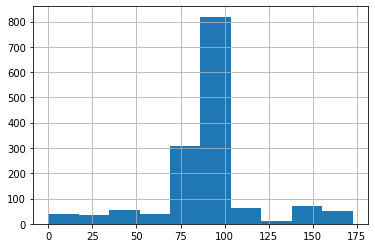

In [31]:
# Let's plot a histogram to visualize the distribution of the observed `test_duration` data points
failures_test2["test_duration"].hist()

In [32]:
# Identify the distribution
d2_failing, r2_failing = fit_distribution(failures_test2, "test_duration", 0.99, 0.01)


Distributions listed by Betterment of fit:
............................................
   Distribution     chi_square and p-value
3          beta  (2148.0315961744586, 0.0)
9      pearson3   (2150.964892187448, 0.0)
1          norm   (2178.439189095538, 0.0)
8       lognorm   (2190.171386750302, 0.0)
6         gamma  (2251.5768352345144, 0.0)
0   weibull_min  (2335.2881528000057, 0.0)
2   weibull_max  (2436.7340969950874, 0.0)
4      invgauss  (2581.7529201615253, 0.0)
10       triang   (3168.817214371956, 0.0)
5       uniform  (5205.7686822999685, 0.0)
7         expon   (7308.400793415922, 0.0)


In [33]:
# Print the parameters for the distributions which are the mu (shape), loc (location)
# and scale parameters
print(d2_failing)

   Distribution Names                                         Parameters
0         weibull_min  (4.6427392075956835, -4.43451289012974, 4.8146...
1                norm                      (-1.171224289714451e-16, 1.0)
2         weibull_max  (3.709430371603564, 3.5732998827356877, 3.9280...
3                beta  (21455.16309160612, 1395.726210285496, -592.66...
4            invgauss  (0.012418119424580355, -9.594365078725424, 773...
5             uniform            (-3.373399521327697, 6.006810353880617)
6               gamma  (634.0538650591961, -25.325828917067867, 0.039...
7               expon            (-3.373399521327697, 3.373399521327697)
8             lognorm  (0.005771872826408885, -173.0123438298847, 173...
9            pearson3  (-0.04208220131814111, -1.7996272495738179e-16...
10             triang  (0.5587835400423031, -3.491790660656199, 6.387...


We see that the top 2 distributions based on betterment of fit are **Pearson** distribution and **Beta** distribution. Let's plot the graphs for these two distributions.

In [34]:
# Fetch the parameters required for respective distribution types to visualize the density plots
pearson_param_failing2 = d2_failing[d2_failing["Distribution Names"] == "pearson3"][
    "Parameters"
].values
# Flatten list
pearson_param_failing2 = list(itertools.chain(*pearson_param_failing2))
beta_param_failing2 = d2_failing[d2_failing["Distribution Names"] == "beta"][
    "Parameters"
].values
# Flatten list
beta_param_failing2 = list(itertools.chain(*beta_param_failing2))

In [35]:
y_std_failing2, len_y_failing2, y_failing2 = standardize(
    failures_test2, "test_duration", 0.99, 0.01
)

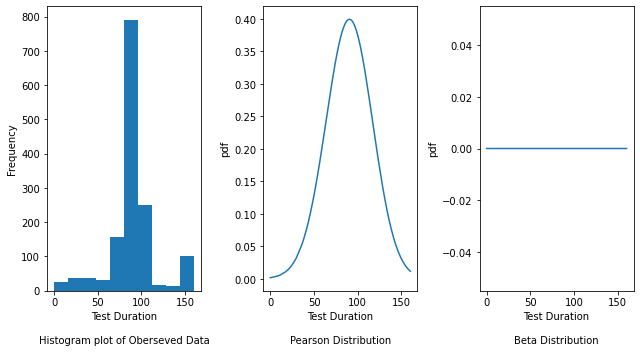

In [36]:
# Plot the distributions
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(9, 5))
axes[0].hist(y_failing2)
axes[0].set_xlabel("Test Duration\n\nHistogram plot of Oberseved Data")
axes[0].set_ylabel("Frequency")
# Plot the density plot for Pearson distribution by passing the mu (shape parameter), loc (location)
# and scale parameters obtained from above
axes[1].plot(
    y_failing2,
    pearson3.pdf(
        y_std_failing2,
        pearson_param_failing2[0],
        pearson_param_failing2[1],
        pearson_param_failing2[2],
    ),
)
axes[1].set_xlabel("Test Duration\n\nPearson Distribution")
axes[1].set_ylabel("pdf")
# Plot the density plot for Beta distribution by passing the mu (shape), loc (location) and
# scale parameters obtained from above
axes[2].plot(
    y_failing2,
    beta.pdf(
        y_std_failing2,
        beta_param_failing2[0],
        beta_param_failing2[1],
        beta_param_failing2[2],
    ),
)
axes[2].set_xlabel("Test Duration\n\nBeta Distribution")
axes[2].set_ylabel("pdf")
fig.tight_layout()

The Histogram plot shows the distribution of test duration values over all the data points. The Pearson and Beta graphs are density plots which are a smoothed, continuous version of a histogram estimated from the data. It plots the probability density function (along Y-axis) vs the test duration values (along X-axis). Probability density plots are used to understand data distribution for a continuous variable and we want to know the likelihood (or probability) of obtaining a range of values that the continuous variable can assume. The area under the curve contains the probabilities for the test duration values.

### Passing Distribution

Let's identify the passing distribution type for the following 2 tests:
* openshift-tests.[sig-arch][Feature:ClusterUpgrade] Cluster should remain functional during upgrade [Disruptive] [Serial]
* operator.Run multi-stage test e2e-aws-upgrade - e2e-aws-upgrade-openshift-e2e-test container test

#### Test: "openshift-tests.[sig-arch][Feature:ClusterUpgrade] Cluster should remain functional during upgrade [Disruptive] [Serial]"

In [37]:
# Filter df for the "openshift-tests.[sig-arch][Feature:ClusterUpgrade] Cluster should remain
# functional during upgrade [Disruptive] [Serial]" test
passing_test1 = filter_test_type(
    passing_df,
    "openshift-tests.[sig-arch][Feature:ClusterUpgrade] Cluster should remain "
    "functional during upgrade [Disruptive] [Serial]",
)
passing_test1.head()

timestamp                           tab  \
0 2021-08-25 13:06:02  "redhat-openshift-informing"   
1 2021-08-25 10:30:05  "redhat-openshift-informing"   
2 2021-08-25 07:15:39  "redhat-openshift-informing"   
3 2021-08-25 06:08:52  "redhat-openshift-informing"   
4 2021-08-25 02:54:53  "redhat-openshift-informing"   

                                              grid  \
0  release-openshift-okd-installer-e2e-aws-upgrade   
1  release-openshift-okd-installer-e2e-aws-upgrade   
2  release-openshift-okd-installer-e2e-aws-upgrade   
3  release-openshift-okd-installer-e2e-aws-upgrade   
4  release-openshift-okd-installer-e2e-aws-upgrade   

                                                test  test_duration  passing  
0  openshift-tests.[sig-arch][Feature:ClusterUpgr...     100.833333     True  
1  openshift-tests.[sig-arch][Feature:ClusterUpgr...      91.416667     True  
2  openshift-tests.[sig-arch][Feature:ClusterUpgr...      94.033333     True  
3  openshift-tests.[sig-arch][Feature:ClusterUpgr...      90.050000     True  
4  openshift-tests.[sig-arch][Feature:ClusterUpgr...      93.450000     True

In [38]:
# Let's plot a histogram to visualize the distribution of the observed `test_duration` data points
passing_test1["test_duration"].hist()

<AxesSubplot:>

In [39]:
# Identify the distribution
d1_passing, r1_passing = fit_distribution(passing_test1, "test_duration", 0.99, 0.01)


Distributions listed by Betterment of fit:
............................................
   Distribution     chi_square and p-value
0   weibull_min   (3099.992757342761, 0.0)
9      pearson3  (3544.0050668290633, 0.0)
3          beta  (3545.4138733281484, 0.0)
2   weibull_max   (4116.375773044669, 0.0)
10       triang   (5930.653942691529, 0.0)
1          norm   (6927.207014523444, 0.0)
8       lognorm   (6935.331882469858, 0.0)
6         gamma   (7086.238475977115, 0.0)
4      invgauss   (8398.626283249283, 0.0)
5       uniform   (11398.67511007455, 0.0)
7         expon  (16826.245420038034, 0.0)


In [40]:
# Print the parameters for the distributions which are the mu (shape), loc (location)
# and scale parameters
print(d1_passing)

   Distribution Names                                         Parameters
0         weibull_min  (23.65606207323377, -18.709459991681634, 19.13...
1                norm        (5.721531843060696e-17, 0.9999999999999999)
2         weibull_max  (2.222323970370051, 2.1309774933239938, 2.4039...
3                beta  (2306.503139113286, 7.609193001177182, -813.46...
4            invgauss  (0.010600285727260642, -10.69823396769825, 100...
5             uniform           (-3.069628193197908, 5.1849198003140575)
6               gamma  (273.05849309091036, -17.350871362303216, 0.06...
7               expon            (-3.069628193197908, 3.069628193197908)
8             lognorm  (0.002206952969157352, -454.25765717799663, 45...
9            pearson3  (-0.7203794023622432, 1.1214076509902137e-16, ...
10             triang  (0.6647839138973428, -3.2331077030700532, 5.37...


We see that the top 2 distributions based on betterment of fit are **Pearson** distribution and **Weibull Min** distribution. Let's plot the graphs for these two distributions.

In [41]:
# Fetch the parameters required for respective distribution types to visualize the density plots
pearson_param_passing1 = d1_passing[d1_passing["Distribution Names"] == "pearson3"][
    "Parameters"
].values
# Flatten list
pearson_param_passing1 = list(itertools.chain(*pearson_param_passing1))
weibull_param_passing1 = d1_passing[d1_passing["Distribution Names"] == "weibull_min"][
    "Parameters"
].values
# Flatten list
weibull_param_passing1 = list(itertools.chain(*weibull_param_passing1))

In [42]:
y_std_passing1, len_y_passing1, y_passing1 = standardize(
    passing_test1, "test_duration", 0.99, 0.01
)

In [43]:
# Plot the distributions
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(9, 5))
axes[0].hist(y_passing1)
axes[0].set_xlabel("Test Duration\n\nHistogram plot of Oberseved Data")
axes[0].set_ylabel("Frequency")
# Plot the density plot for Pearson distribution by passing the mu (shape parameter), loc (location)
# and scale parameters obtained from above
axes[1].plot(
    y_passing1,
    pearson3.pdf(
        y_std_passing1,
        pearson_param_passing1[0],
        pearson_param_passing1[1],
        pearson_param_passing1[2],
    ),
)
axes[1].set_xlabel("Test Duration\n\nPearson Distribution")
axes[1].set_ylabel("pdf")
# Plot the density plot for Weibull Min distribution by passing the mu (shape), loc (location) and
# scale parameters obtained from above
axes[2].plot(
    y_passing1,
    weibull_min.pdf(
        y_std_passing1,
        weibull_param_passing1[0],
        weibull_param_passing1[1],
        weibull_param_passing1[2],
    ),
)
axes[2].set_xlabel("Test Duration\n\nWeibull Min Distribution")
axes[2].set_ylabel("pdf")
fig.tight_layout()

The Histogram plot shows the distribution of test duration values over all the data points. The Pearson and Weibull Min graphs are density plots which are a smoothed, continuous version of a histogram estimated from the data. It plots the probability density function (along Y-axis) vs the test duration values (along X-axis). Probability density plots are used to understand data distribution for a continuous variable and we want to know the likelihood (or probability) of obtaining a range of values that the continuous variable can assume. The area under the curve contains the probabilities for the test duration values.

#### Test: "operator.Run multi-stage test e2e-aws-upgrade - e2e-aws-upgrade-openshift-e2e-test container test"

In [44]:
# Filter df for the "operator.Run multi-stage test e2e-aws-upgrade - e2e-aws-upgrade-openshift-e2e-test
# container test" test
passing_test2 = filter_test_type(
    passing_df,
    "operator.Run multi-stage test e2e-aws-upgrade - "
    "e2e-aws-upgrade-openshift-e2e-test container test",
)
passing_test2.head()

timestamp                           tab  \
0 2021-08-25 13:06:02  "redhat-openshift-informing"   
1 2021-08-25 07:15:39  "redhat-openshift-informing"   
2 2021-08-25 06:08:52  "redhat-openshift-informing"   
3 2021-08-25 02:54:53  "redhat-openshift-informing"   
4 2021-08-24 22:40:00  "redhat-openshift-informing"   

                                              grid  \
0  release-openshift-okd-installer-e2e-aws-upgrade   
1  release-openshift-okd-installer-e2e-aws-upgrade   
2  release-openshift-okd-installer-e2e-aws-upgrade   
3  release-openshift-okd-installer-e2e-aws-upgrade   
4  release-openshift-okd-installer-e2e-aws-upgrade   

                                                test  test_duration  passing  
0  operator.Run multi-stage test e2e-aws-upgrade ...     101.250000     True  
1  operator.Run multi-stage test e2e-aws-upgrade ...      94.283333     True  
2  operator.Run multi-stage test e2e-aws-upgrade ...      90.316667     True  
3  operator.Run multi-stage test e2e-aws-upgrade ...      93.866667     True  
4  operator.Run multi-stage test e2e-aws-upgrade ...      92.900000     True

In [45]:
# Let's plot a histogram to visualize the distribution of the observed `test_duration` data points
passing_test2["test_duration"].hist()

<AxesSubplot:>

In [46]:
# Identify the distribution
d2_passing, r2_passing = fit_distribution(passing_test2, "test_duration", 0.99, 0.01)


Distributions listed by Betterment of fit:
............................................
   Distribution                         chi_square and p-value
10       triang     (461.9624452114939, 4.799796517458444e-69)
3          beta    (619.2886679176573, 2.716009412709153e-100)
2   weibull_max   (782.1495727872282, 2.4780499811803997e-133)
5       uniform   (800.7205543332755, 3.9377128547833523e-137)
9      pearson3     (902.4903827437414, 4.87937692523532e-158)
0   weibull_min   (961.9366558978377, 2.6033191498811774e-170)
6         gamma   (1025.0253918219983, 2.234474698949537e-183)
8       lognorm  (1063.4355506988115, 2.3726995807065007e-191)
1          norm    (1066.204889931689, 6.306900543032179e-192)
4      invgauss     (1076.96978515332, 3.650894820526847e-194)
7         expon                      (2457.1474484587093, 0.0)


In [47]:
# Print the parameters for the distributions which are the mu (shape), loc (location)
# and scale parameters
print(d2_passing)

   Distribution Names                                         Parameters
0         weibull_min  (12.20521715428722, -9.947987307617899, 10.381...
1                norm                      (-2.900174431673878e-16, 1.0)
2         weibull_max  (2.1554319735307503, 2.0437822972560094, 2.308...
3                beta  (3.7771834527281305, 2.2909268094664883, -3.38...
4            invgauss  (0.012936695580847705, -9.3755847909988, 723.7...
5             uniform          (-2.2137979788672366, 4.1716330057230735)
6               gamma  (234.71277775898807, -15.756136680990146, 0.06...
7               expon           (-2.2137979788672366, 2.213797978867236)
8             lognorm  (0.002403707049861004, -416.90701811718577, 41...
9            pearson3  (-0.7785824858250469, -3.4824148365068255e-16,...
10             triang  (0.6841968667427839, -2.6090072152614505, 4.63...


We see that the top 2 distributions based on betterment of fit are **Pearson** distribution and **Triangular** distribution. Let's plot the graphs for these two distributions.

In [48]:
# Fetch the parameters required for respective distribution types to visualize the density plots
pearson_param_passing2 = d2_passing[d2_passing["Distribution Names"] == "pearson3"][
    "Parameters"
].values
# Flatten list
pearson_param_passing2 = list(itertools.chain(*pearson_param_passing2))
triang_param_passing2 = d2_passing[d2_passing["Distribution Names"] == "triang"][
    "Parameters"
].values
# Flatten list
triang_param_passing2 = list(itertools.chain(*triang_param_passing2))

In [49]:
y_std_passing2, len_y_passing2, y_passing2 = standardize(
    passing_test2, "test_duration", 0.99, 0.01
)

In [50]:
# Plot the distributions
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(9, 5))
axes[0].hist(y_passing2)
axes[0].set_xlabel("Test Duration\n\nHistogram plot of Oberseved Data")
axes[0].set_ylabel("Frequency")
# Plot the density plot for Pearson distribution by passing the mu (shape parameter), loc (location)
# and scale parameters obtained from above
axes[1].plot(
    y_passing2,
    pearson3.pdf(
        y_std_passing2,
        pearson_param_passing2[0],
        pearson_param_passing2[1],
        pearson_param_passing2[2],
    ),
)
axes[1].set_xlabel("Test Duration\n\nPearson Distribution")
axes[1].set_ylabel("pdf")
# Plot the density plot for Triangular distribution by passing the mu (shape), loc (location) and
# scale parameters obtained from above
axes[2].plot(
    y_passing2,
    triang.pdf(
        y_std_passing2,
        triang_param_passing2[0],
        triang_param_passing2[1],
        triang_param_passing2[2],
    ),
)
axes[2].set_xlabel("Test Duration\n\nTriangular Distribution")
axes[2].set_ylabel("pdf")
fig.tight_layout()

The Histogram plot shows the distribution of test duration values over all the data points. The Pearson and Triangular graphs are density plots which are a smoothed, continuous version of a histogram estimated from the data. It plots the probability density function (along Y-axis) vs the test duration values (along X-axis). Probability density plots are used to understand data distribution for a continuous variable and we want to know the likelihood (or probability) of obtaining a range of values that the continuous variable can assume. The area under the curve contains the probabilities for the test duration values.

## Optimal Stopping Point
Next, we would want to look into these distribution types to determine a point after which the test has a higher probability of failing.

### Test: "openshift-tests.[sig-arch][Feature:ClusterUpgrade] Cluster should remain functional during upgrade [Disruptive] [Serial]"
*Distribution Type*: **Log Normal**

For the test "openshift-tests.[sig-arch][Feature:ClusterUpgrade] Cluster should remain functional during upgrade [Disruptive] [Serial]", let's look at the `Log Normal` distribution type.

To find the optimal stopping point, we will find the intersection points for the passing and failing distribution curves using the `intersect` library. We will then consider the largest `x` co-ordinate value (i.e the test duration value) as the corresponding optimal stopping point.

In [51]:
# Fetch the parameters for the log normal distribution of passing test1
lognorm_param_passing1 = d1_passing[d1_passing["Distribution Names"] == "lognorm"][
    "Parameters"
].values
# Flatten list
lognorm_param_passing1 = list(itertools.chain(*lognorm_param_passing1))

In [52]:
# Obtain the intersection points between the distribution curves
x1, y1 = intersection(
    y_failing1,
    lognorm.pdf(
        y_std_failing1,
        lognorm_param_failing1[0],
        lognorm_param_failing1[1],
        lognorm_param_failing1[2],
    ),
    y_passing1,
    lognorm.pdf(
        y_std_passing1,
        lognorm_param_passing1[0],
        lognorm_param_passing1[1],
        lognorm_param_passing1[2],
    ),
)
# Print the x co-ordinates of the intersection points which corresponds to the test duration values
print(x1)

[19.31628303 19.35340261 45.87843304 72.01245346]


In [53]:
fig, ax = plt.subplots()
ax.plot(
    y_failing1,
    lognorm.pdf(
        y_std_failing1,
        lognorm_param_failing1[0],
        lognorm_param_failing1[1],
        lognorm_param_failing1[2],
    ),
    label="Failure Distribution",
)
ax.plot(
    y_passing1,
    lognorm.pdf(
        y_std_passing1,
        lognorm_param_passing1[0],
        lognorm_param_passing1[1],
        lognorm_param_passing1[2],
    ),
    label="Passing Distribution",
)
ax.set_xlabel("Test Duration")
ax.set_ylabel("pdf")
ax.set_title("Test Duration vs Probability Density Function")
# vertical intersection point corresponding to largest x co-ordinate value
ax.axvline(x=max(x1), color="r", label="Optimal Stopping Point")
fig.tight_layout()
plt.legend()
plt.show()

From the above graph, we see that passing tests (orange line) have a narrower range and smaller std, with an expected run time of between 20 and 110 seconds. Failing tests (blue line) are much less reliable with a run time spanning from 0 to 240 seconds. From this graph, we can claim that a test run longer than ~72 seconds starts to have an increased probability of being a failure and hence can be considered as an optimal stopping point.

### Test: "operator.Run multi-stage test e2e-aws-upgrade - e2e-aws-upgrade-openshift-e2e-test container test"
*Distribution Type*: **Person**

For the test "operator.Run multi-stage test e2e-aws-upgrade - e2e-aws-upgrade-openshift-e2e-test container test", let's look at the `Pearson` distribution type.

To find the optimal stopping point, we will find the intersection points for the passing and failing distribution curves using the `intersect` library. We will then consider the largest `x` co-ordinate value (i.e the test duration value) as the corresponding optimal stopping point.

In [54]:
# Obtain the intersection points between the distribution curves
x2, y2 = intersection(
    y_failing2,
    pearson3.pdf(
        y_std_failing2,
        pearson_param_failing2[0],
        pearson_param_failing2[1],
        pearson_param_failing2[2],
    ),
    y_passing2,
    pearson3.pdf(
        y_std_passing2,
        pearson_param_passing2[0],
        pearson_param_passing2[1],
        pearson_param_passing2[2],
    ),
)
# Print the x co-ordinates of the intersection points which corresponds to the test duration values
print(x2)

[ 86.243292   104.17407072]


In [55]:
fig, ax = plt.subplots()
ax.plot(
    y_failing2,
    pearson3.pdf(
        y_std_failing2,
        pearson_param_failing2[0],
        pearson_param_failing2[1],
        pearson_param_failing2[2],
    ),
    label="Failure Distribution",
)
ax.plot(
    y_passing2,
    pearson3.pdf(
        y_std_passing2,
        pearson_param_passing2[0],
        pearson_param_passing2[1],
        pearson_param_passing2[2],
    ),
    label="Passing Distribution",
)
ax.set_xlabel("Test Duration")
ax.set_ylabel("pdf")
ax.set_title("Test Duration vs Probability Density Function")
# vertical intersection point corresponding to largest x co-ordinate value
ax.axvline(x=max(x2), color="r", label="Optimal Stopping Point")
fig.tight_layout()
plt.legend()
plt.show()

From the above graph, we see that passing tests (orange line) have a narrower range and smaller std, with an expected run time of between 40 and 120 seconds. Failing tests (blue line) are much less reliable with a run time spanning from 0 to 160 seconds. From this graph, we can claim that a test run longer than ~104 seconds starts to have an increased probability of being a failure and hence can be considered as an optimal stopping point.

## Conclusion:

In this notebook, we have filtered the TestGrid data for failing and passing tests and identified the distributions for different TestGrid tests for the feature `test_duration`. We have observed that different TestGrid tests have different types of distributions. Based on the distribution type, we performed Chi-Square statistics for each distribution and further sorted them to find the best distribution. We then determine an optimal stopping point by plotting the intersection points between the passing and failing test distributions. For future work, we aim to develop an ML model to predict an optimal stopping point for each test considering the distribution type so as to make appropriate predictions.